In [4]:
import numpy as np
import mne
from moabb.datasets import BNCI2014_001
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score, recall_score, precision_score
import tensorflow as tf
from pprint import pprint
from model import build_FNN40_basis

2025-06-13 02:27:23.304643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 02:27:23.323985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 02:27:23.324008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 02:27:23.324589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 02:27:23.328118: I tensorflow/core/platform/cpu_feature_guar

In [17]:
def load_raw_trials(subject, session):
    # BNCI2014_001 (BCI Competition IV 2A) 데이터셋을 로드
    dataset = BNCI2014_001()

    # 특정 subject(participant)의 특정 session(training or validation)을 가져옴
    runs = dataset._get_single_subject_data(subject)[session]

    # 데이터를 저장할 리스트
    X_all, y_all = [], []

    # Sampling frequency (처음 run에서 추출 후 고정)
    sfreq = None

    # Session 내의 각 run(파일 단위)마다 반복
    for run_key in runs.keys():
        raws = runs[run_key]

        # 첫 번째 run에서 sampling frequency 저장 : 255
        if sfreq is None:
            sfreq = int(raws.info["sfreq"])
            print(f"  Sampling frequency (sfreq): {sfreq} Hz")

        # 이벤트 추출 (자극 채널 'stim'에서 이벤트 탐지)
        events = mne.find_events(raws, stim_channel='stim', shortest_event=0, verbose=False)

        # 이벤트가 없으면 이 run은 건너뜀
        if len(events) == 0:
            print("    [Warning] No events found in this run.")
            continue

        # Imagined movement class: left(1), right(2), feet(3), tongue(4)
        movement_ids = [1, 2, 3, 4] 
        movement_events = np.array([e for e in events if e[2] in movement_ids])

        # Class label 매핑 (MNE의 Epochs에서 사용)
        event_id = {'left': 1, 'right': 2, 'feet': 3, 'tongue': 4}
        '''
        각 movement event에 대해 trial 추출
        - tmin=0, tmax=8: 자극 시점부터 8초까지의 전체 trial 구간 사용
        - baseline=None: baseline 보정 안 함
        - preload=True: 데이터를 즉시 메모리에 로딩
        '''
        epochs = mne.Epochs(raws, movement_events, event_id=event_id, tmin=0, tmax=8, baseline=None, preload=True)
        
        # 22 channel EEG만 추출 (EOG 등 제외), shape: (n_trials, 22, time_points)
        X = epochs.get_data()[:, :22, :]

        # 해당 trial들의 class label 정보 추출
        y_events = epochs.events[:, 2]  
        
        # 결과 누적
        X_all.append(X)
        y_all.append(y_events)

    # 여러 run에서 수집한 데이터를 하나로 합침
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    
    # EEG 데이터, 레이블, 샘플링 주파수 반환
    return X_all, y_all, sfreq

In [18]:
'''
Sampling frequency (sfreq): 250 Hz
- 이 run의 EEG 데이터가 1초에 250번 sampling됐다는 뜻이다.

[[  250     0     4]
 [ 2253     0     3]
 [ 4171     0     2]
 ...
 [94757     0     1]]
- 각 행은 하나의 event를 나타낸다
    sample_idx: 이 event가 시작되는 sample 번호
    0: 사용하지 않는 자리
    event_code: 이 tiral에서 상상해야 할 동작
- 예시 해석
    [250, 0, 4]: 250번째 sample (1초=250 sampledlamfh t=1.0s)에서 4(tongue) event 시작
    [2253, 0, 4]: 2253번째 sample (t=9.012s)에서 3(feet) event 시작
    이렇게 48개의 event이 감지된다.

48 matching events found
- 총 48개의 movement trial이 run에 포함되어 있음을 의미
    BCI Competition IV 2A는 한 run에 48 trials, 6 run x 48 = 288 trial

Using data from preloaded Raw for 48 events and 2001 original time points ...
- preloaded Raw 객체에서 48개의 event

'''

X_train, y_events_train, sfreq = load_raw_trials(1, "0train")
print(X_train)

  Sampling frequency (sfreq): 250 Hz
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 2001 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 2001 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 2001 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 2001 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 

In [19]:
print("원본: 첫 trial 첫 채널 통계")
print("mean:", np.mean(X_train[0,0,:]))
print("std:", np.std(X_train[0,0,:]))
print("min:", np.min(X_train[0,0,:]))
print("max:", np.max(X_train[0,0,:]))
print("raw values (first 10):", X_train[0,0,:10])

원본: 첫 trial 첫 채널 통계
mean: 5.194912309470266e-07
std: 1.2744058466577534e-05
min: -3.8330078125e-05
max: 6.181640625e-05
raw values (first 10): [-9.17968750e-06 -5.71289063e-06 -6.88476562e-06 -3.80859375e-06
 -6.59179687e-06  4.68750000e-06  1.51367187e-06 -2.29492188e-06
 -3.61328125e-06 -4.58984375e-06]


In [21]:
def preprocess_trials(X):
    X_proc = []
    for trial in X:
        # (1) Smoothing: Savitzky-Golay filter (moving local polynomial regression)
        '''
        논문 3.1.1의 수식 (2)에 기반한 Local Polynomial Estimator 적용

        여기서는 Savitzky-Golay 필터로 이를 실용적으로 구현:
        - window_length=5 : 논문에서의 bandwidth h 에 대응됨
        - polyorder=3 : 논문 수식에서의 다항식 차수 p 에 대응됨
        - axis=-1 : 시간축 기준으로 필터링 수행 (trial shape: [channels, time])
        '''
        trial = savgol_filter(trial, window_length=5, polyorder=3, axis=-1)
        # (2) Standardization: channel-wise Z-score normalization
        '''
        논문 3.1.2 Normalization

        이는 함수형 Z-score 정규화와 동일한 구조로,
        각 채널(함수)을 평균 0, 분산 1로 정규화함.
        
        코드에서는 discrete version으로 다음을 수행:
        - trial.T: shape을 (time, channels)로 바꿔 각 채널을 feature로 봄
        - StandardScaler().fit_transform(): 각 채널에 대해 평균과 표준편차를 구해 Z-score 정규화
        - 다시 .T로 전치하여 원래 (channels, time) 형태로 복원
        '''
        trial = StandardScaler().fit_transform(trial.T).T
        X_proc.append(trial)
    return np.array(X_proc)

In [22]:
X_train_proc = preprocess_trials(X_train)

In [23]:
print("전처리 후: 첫 trial 첫 채널 통계")
print("mean:", np.mean(X_train_proc[0,0,:]))
print("std:", np.std(X_train_proc[0,0,:]))
print("min:", np.min(X_train_proc[0,0,:]))
print("max:", np.max(X_train_proc[0,0,:]))
print("proc values (first 10):", X_train_proc[0,0,:10])

전처리 후: 첫 trial 첫 채널 통계
mean: -7.101876419391306e-18
std: 0.9999999999999999
min: -2.986378029593293
max: 4.723903158373814
proc values (first 10): [-0.74864725 -0.58109024 -0.45867669 -0.54807735 -0.23500885  0.04283114
  0.15172935 -0.18759437 -0.30491197 -0.56292207]


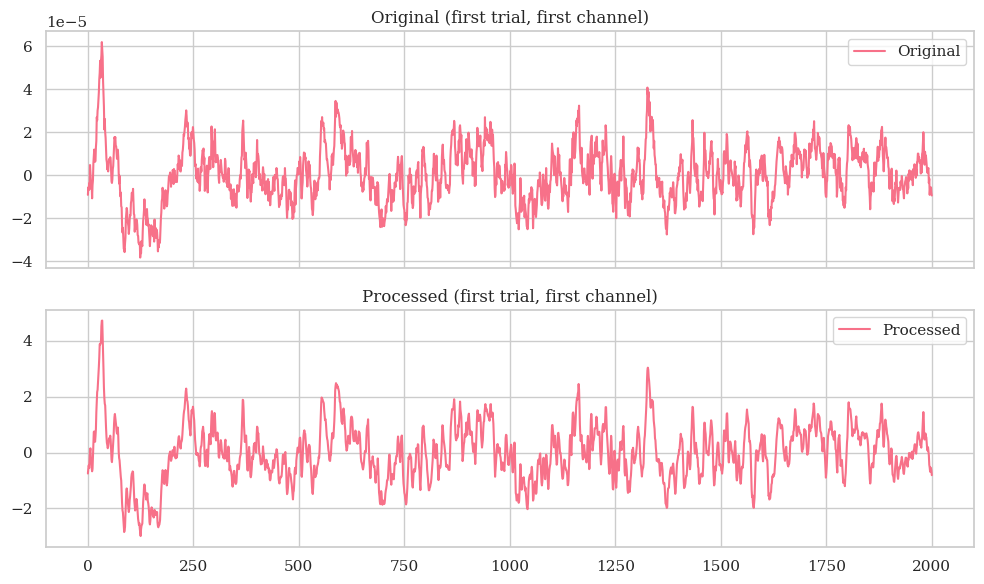

In [24]:
import matplotlib.pyplot as plt

# 원본 데이터 (smoothing/정규화 전)
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(X_train[0, 0, :], label='Original')
axs[0].set_title('Original (first trial, first channel)')
axs[0].legend()

# 전처리 데이터 (smoothing/정규화 후)
axs[1].plot(X_train_proc[0, 0, :], label='Processed')
axs[1].set_title('Processed (first trial, first channel)')
axs[1].legend()
plt.tight_layout()
plt.show()
